In [67]:
from dataloader import val_transform, inference_transform_with_rotating
from autoencoder import Encoder

import os
import PIL
import numpy as np
import shutil 
from sklearn.neighbors import NearestNeighbors
from skimage import io
import torch
import glob
import matplotlib.pyplot as plt

# some useful functions
def round_with_None(x):
    if x is None:
        return x
    else:
        return round(x, 5)

def get_image_path_by_id(idx):
    if os.path.exists('data/train/data/' + idx):
        return 'data/train/data/' + idx
    elif os.path.exists('data/val/data/' + idx):
        return 'data/val/data/' + idx
    else:
        raise FileNotFoundError


In [98]:
# find similar encoding using nearest neighbors algorithm
def similarity(encoder_predict, num, code_size):

    try:
        codes = np.load('embedding/codes.{}.npy'.format(code_size))
        filenames_and_coords = np.load('embedding/filenames.{}.npy'.format(code_size))
    except:
        raise FileNotFoundError('embedding/filenames.{}.npy'.format(code_size))
    
    nn = NearestNeighbors()
    nn.fit(codes, y=filenames_and_coords)

    dist, idx = nn.kneighbors(encoder_predict, n_neighbors=num)
    return dist, filenames_and_coords[idx]

def predict(image_path, weights, code_size=64, num=10, device='cpu', random_rotate=False):
    # load encoder
    encoder = Encoder(code_size)
    encoder.load_state_dict(torch.load(weights, map_location=device))
    encoder.eval()

    # load image
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    if not os.path.exists(image_name):
        os.mkdir(image_name)
    else:
        print('Folder was {}/ exist already'.format(image_name))
        shutil.rmtree(image_name)
        os.mkdir(image_name)


    if not os.path.exists(image_path):
        raise FileNotFoundError
    image = PIL.Image.fromarray(io.imread(image_path))
    
    if random_rotate:
        best_distances = []
        best_filenames_and_coords = []
        for i in range(5):
            # find similar num galaxies
            tensor_image = inference_transform_with_rotating(image).to(device)
            with torch.no_grad():
                encoder_predict = encoder(tensor_image[None]).cpu().numpy()
            distances, filenames_and_coords = similarity(encoder_predict, num, code_size)
            distances =  distances[0]
            filenames_and_coords = filenames_and_coords[0]
            best_distances.extend(distances)
            best_filenames_and_coords.extend(filenames_and_coords)

        best_distances = np.array(best_distances)
        best_filenames_and_coords = np.array(best_filenames_and_coords)
        inds = best_distances.argsort()
        distances = best_distances[inds][:num]
        filenames_and_coords = best_filenames_and_coords[inds][:num]
    else:
        tensor_image = val_transform(image).to(device)

        # find similar num galaxies
        with torch.no_grad():
            encoder_predict = encoder(tensor_image[None]).cpu().numpy()
        distances, filenames_and_coords = similarity(encoder_predict, num, code_size)
        distances =  distances[0]
        filenames_and_coords = filenames_and_coords[0]

    # save txt (id, coords and probability) and images in folder with the same name as image_path but without extension
    for fac, dist in zip(filenames_and_coords, distances):

        # get id and coordinate
        idx = fac[0]
        ra = round_with_None(fac[1])
        dec = round_with_None(fac[2])
        dist = round_with_None(dist)

        # overwrite image in new folder
        path_read = get_image_path_by_id(idx)
        id_of_predicted = os.path.splitext(os.path.basename(path_read))[0]
        path_save = os.path.join(image_name, (os.path.basename(path_read)))
        shutil.copyfile(path_read, path_save)
        print(' '.join([str(id_of_predicted), str(ra), str(dec), str(dist)]))

    
    print('Similar images saved in {}'.format(image_name))
        

In [109]:
# source image
image_path = 'examples/587725818552713323.jpg'
# get image name without extension
image_name = os.path.splitext(os.path.basename(image_path))[0]

# There are 2 model: with code size 64 and 32; work about the same, but 32 are more efficient in memory  
code_size = 32
weights = 'models/encoder.{}.pth'.format(code_size)

device = 'cpu'
num = 10
random_rotate = True

predict(image_path, weights, code_size, num, device, random_rotate)

Folder was 587725818552713323/ exist already
587735348038533272 None None 0.15643
587725818552713323 141.56996 61.38153 0.18063
587741602568994827 185.01988 27.97533 0.22725
587741727648579619 175.23488 25.78092 0.22895
587738948286677009 162.11625 38.39717 0.23132
587725040092446735 181.19667 -2.72008 0.24555
588017111299260431 195.23154 47.22211 0.2538
587742576453877812 212.82442 17.50644 0.25883
587732484343005252 132.344 36.71033 0.26415
587741726583423011 196.92842 24.81058 0.27148
Similar images saved in 587725818552713323


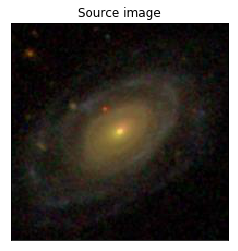

In [114]:
# visualize
source_image = plt.imread(image_path)
plt.imshow(source_image)
plt.xticks([])
plt.yticks([])
plt.title('Source image');


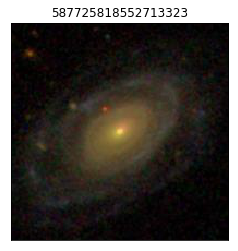

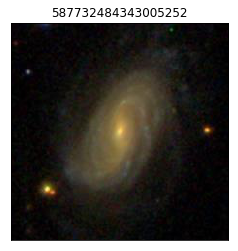

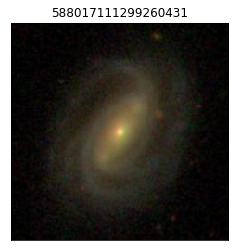

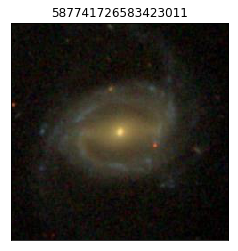

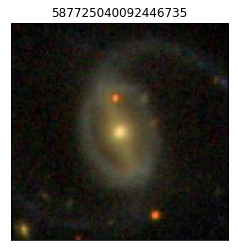

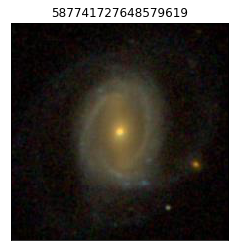

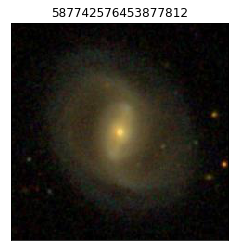

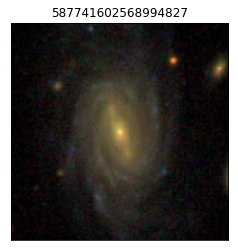

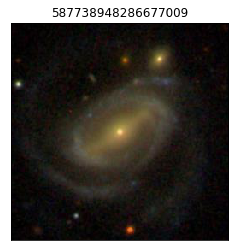

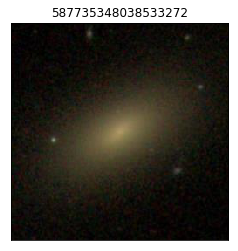

In [110]:
predicted_list = glob.glob('{}/*.jpg'.format(image_name))
for i, filename in enumerate(predicted_list):
    img = plt.imread(filename)
    plt.xticks([])
    plt.yticks([])
    plt.title(os.path.splitext(os.path.basename(filename))[0])
    plt.imshow(img)
    plt.show()